In [409]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def is_pareto_efficient(costs):
    """
    :param costs: An (n_points, n_costs) array
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient]<=c, axis=1)  # Remove dominated points
    return is_efficient

# In[94]:
def get_pareto_points(files, outputs):
    brk_col = "Avg FU Dynamic Power"
    dfs = []

    for f in files:
        dfs.append(pd.read_csv(f, index_col=0))

    df = pd.concat(dfs)
    df.reset_index(drop=True, inplace=True)
    df.drop(['arrays'], axis=1, inplace=True)
    inputs = set(df.columns) - set(outputs) #df.columns.tolist()[:df.columns.tolist().index("Avg FU Dynamic Power")]
#     df['Avg Power'] = df['Avg Power']
    for c in df.columns:
        if 'area' in c.lower():
            df[c] = df[c] / 1000000 # convert um^2 to mm^2
#     df['Total Area'] = df['Total Area'] / 1000000
    df['Runtime'] = (df['Cycle '] * df.cycle_time).values / 1000000 # Runtime in ms
    input_data = df.loc[:,set(df.columns) - set(outputs)]
    output_data = df.loc[:,outputs]
    dat = output_data.as_matrix()
    mask = is_pareto_efficient(dat)
    data = output_data[mask].sort_values(outputs)
    return data, input_data[mask]




def plot_pareto3d(data, outputs, hold=False, color='r', label=None):
    global ax
    global labels
    global UNIT_LABELS
    X_LABEL = outputs[0]
    Y_LABEL = outputs[1]
    Z_LABEL = outputs[2]
    x = data.loc[:,X_LABEL].values
    y = data.loc[:,Y_LABEL].values
    z = data.loc[:,Z_LABEL].values
    
    plt.xlabel(UNIT_LABELS[X_LABEL])
    plt.ylabel(UNIT_LABELS[Y_LABEL])
    ax.set_zlabel(zlabel=UNIT_LABELS[Z_LABEL])
    plt.xlim(xmin=0.0)
    plt.xlim(xmax=max(x)*1.1)
    plt.ylim(ymin=0.0)
    plt.ylim(ymax=max(y)*1.1)
#     plt.xlim(zmin=0.0)
#     plt.xlim(zmax=max(z))
    alphas = 0.8
    marker = 'o'
    ax.scatter(x,y,z,c=color, marker=marker,alpha = alphas, s=SIZE)
    global v
    if v in data.index.values:
        print(data.index.values)
        print("Showing ", v)
        xv = data.loc[v,X_LABEL]
        yv = data.loc[v,Y_LABEL]
        zv = data.loc[v,Z_LABEL]
        ax.scatter(xv,yv, zv,c='y', marker='v',alpha = alphas, s=SIZE*10)
    # ax.plot(x,y,z,c=color, marker=marker,alpha = alphas)
    if not label is None:
        lines.append( mpl.lines.Line2D([0],[0], linestyle="none", c=color, marker='o') )
        labels.append(label)
    for xv, yv, zv, l in zip(x, y, z, [str(x) for x in data.index.values.tolist()]):
        ax.text(xv, yv, zv, l)
    if hold:
        plt.hold(True)
    else:
        if not label is None:
            ax.legend(lines, labels, numpoints = 1)
        plt.show()



def plot_pareto2d(data, outputs, hold=False, color='r', label=None, save_name=None):
    global ax
    global labels
    global UNIT_LABELS
    X_LABEL = outputs[0]
    Y_LABEL = outputs[1]
    x = data.loc[:,X_LABEL].values
    y = data.loc[:,Y_LABEL].values
    plt.xlim(xmin=0.0)
    plt.xlim(xmax=max(x)*1.1)
    plt.ylim(ymin=0.0)
    plt.ylim(ymax=max(y)*1.1)
    
    plt.xlabel(UNIT_LABELS[X_LABEL])
    plt.ylabel(UNIT_LABELS[Y_LABEL])
    
    ax.set_title("".join(["Pareto Frontier Projected to ",X_LABEL, " and ", Y_LABEL, " Space"]) )
    alphas = 0.8
    marker = 'o'
    # ax.plot(x,y,z,c=color, marker=marker,alpha = alphas)
    if not label is None:
        lines.append( ax.scatter(x,y,c=color, marker=marker,alpha = alphas, s=SIZE, label=label) )
        labels.append(label)
    else:
        ax.scatter(x,y,c=color, marker=marker,alpha = alphas, s=SIZE)
    global v
    if v in data.index.values:
        print("Showing ", v)
        xv = data.loc[v,X_LABEL]
        yv = data.loc[v,Y_LABEL]
        ax.scatter(xv,yv,c='y', marker='v',alpha = alphas, s=SIZE*10)
#     for xv, yv, l in zip(x, y, [str(x) for x in data.index.values]):
#         ax.text(xv, yv, l)
    if hold:
        plt.hold(True)
    else:
        if not label is None:
            ax.legend(lines, labels, numpoints = 1, loc='lower right')
        if save_name is not None:
            plt.savefig(save_name, dpi = 300, bbox_inches='tight')
        else:
            plt.show()




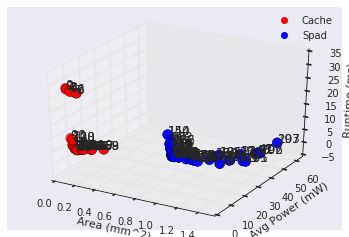

In [410]:
SIZE = 100
v = None

UNIT_LABELS={"Runtime": "Runtime (ms)" , "Total Area": "Area (mm^2)", "Avg Power": "Avg Power (mW)"}
fig = plt.figure()
ax = fig.gca(projection='3d')
lines = []
labels = []

files1 = ["smart_64x64_CACHE.csv", "64x64_CACHE_SMART_2.csv"]
files2 = ["64x64_SPAD.csv", "64x64_SPAD_2_block.csv", "64x64_SPAD_3_cyclic.csv"]
outputs = ["Total Area", "Avg Power", "Runtime"]

data1, _ = get_pareto_points(files1, outputs)
data2, _ = get_pareto_points(files2, outputs)
# plt.show()

plot_pareto3d(data1, outputs, hold=True, color='r', label='Cache')
plot_pareto3d(data2, outputs, hold=False, color='b', label='Spad')

# Do 2d plots:
fig = plt.figure()
ax = fig.gca()
lines = []
labels = []
plot_pareto2d(data1, ["Runtime", "Avg Power"], hold=True, color='r', label='Cache')
plot_pareto2d(data2, ["Runtime", "Avg Power"], hold=False, color='b', label='Spad', \
              save_name = 'Runtime_Power_Pareto.png')


fig = plt.figure()
ax = fig.gca()
lines = []
labels = []
plot_pareto2d(data1, ["Total Area", "Avg Power"], hold=True, color='r', label='Cache')
plot_pareto2d(data2, ["Total Area", "Avg Power"], hold=False, color='b', label='Spad',\
              save_name = 'Area_Power_Pareto.png')


fig = plt.figure()
ax = fig.gca()
lines = []
labels = []
plot_pareto2d(data1, ["Runtime", "Total Area"], hold=True, color='r', label='Cache')
plot_pareto2d(data2, ["Runtime", "Total Area"], hold=False, color='b', label='Spad', \
              save_name = "Runtime_Area_Pareto.png")


In [391]:
data1.loc[24,:]
data1.loc[26,:]
data2.loc[164,:]
data2.loc[160,:]

Total Area     0.936028
Avg Power     19.035500
Runtime        4.384350
Name: 160, dtype: float64

In [411]:
all_pts, all_inputs = get_pareto_points(files1+files2, outputs)

In [412]:
all_pts['PPDP'] = all_pts.apply(lambda row: row['Avg Power'] * row['Avg Power'] * row.Runtime, axis = 1 )

In [413]:
all_pts.sort_values(['PPDP'], ascending = [1], axis=0, inplace=True)
# all_pts.reset_index(drop=True, inplace=True)

In [414]:
all_pts

,Total Area,Avg Power,Runtime,PPDP
0,0.102235,2.36175,29.204305,162.897614
96,0.099597,4.08248,9.940400,165.673098
1,0.107524,2.42021,28.929110,169.449845
2,0.107524,2.42021,28.929110,169.449845
12,0.099597,5.20829,6.957910,188.742248
99,0.099597,5.20829,6.957910,188.742248
13,0.099789,5.37851,6.682600,193.316724
14,0.099789,5.37851,6.682600,193.316724
24,0.099597,6.20780,5.484080,211.338789
26,0.099789,6.45784,5.228770,218.059042


[  0  96   1   2  12  99  13  14  24  26  25 108 120 102  36  72  37  38
  48 105  49  50   3   4   5 114 126  51 106 117  78  53  52 129  81   6
  93   7   8 130  54 107  56  55 119  58  59 251 245 304 310 305 311 303
 309 315 321 316 322 146 152 153 147 317 323 150 144 177 171 333 327 148
 154 155 149 172 178 328 334 173 179 329 335]
Showing  96


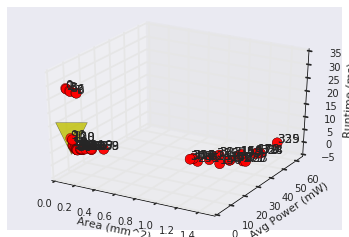

Showing  96


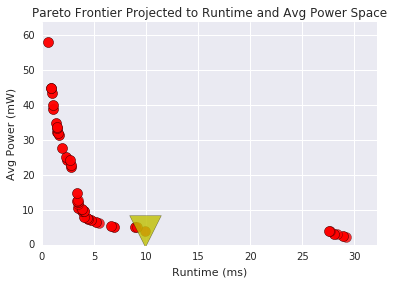

Showing  96


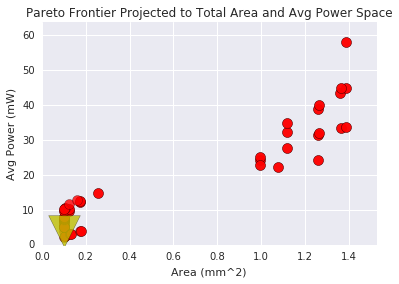

Showing  96


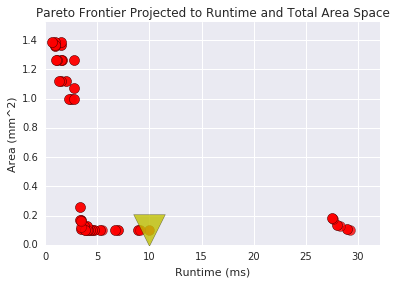

In [418]:
fig = plt.figure()
ax = fig.gca(projection='3d')
lines = []
labels = []
v = 96
plot_pareto3d(all_pts, outputs, color='r')
fig = plt.figure()
ax = fig.gca()
lines = []
labels = []
plot_pareto2d(all_pts, ["Runtime", "Avg Power"], color='r')
fig = plt.figure()
ax = fig.gca()
lines = []
labels = []
plot_pareto2d(all_pts, ["Total Area", "Avg Power"], color='r')
fig = plt.figure()
ax = fig.gca()
lines = []
labels = []
plot_pareto2d(all_pts, ["Runtime", "Total Area"],color='r')

In [225]:
great_design = all_inputs.loc[96, :]
great_design

Avg FU leakage Power                                          0.749308
cache_queue_size                                                    32
Idle FU Cycles                                                 1192091
cache_size                                                         8kB
pipelined_dma                                                      NaN
ready_mode                                                         NaN
mat_size                                                            64
dma_chunk_size                                                     NaN
spad_ports                                                         NaN
unrolling_factor_norm                                               16
unrolling_factor_sub                                                 4
Num of Shifters (32-bit)                                             2
Avg FU Power                                                   2.84823
Num of Registers (32-bit)                                          194
Avg ME

In [419]:
memA = great_design['MEM Area']/all_pts.loc[v,'Total Area']
fuA = great_design['FU Area']/all_pts.loc[v,'Total Area']
print(memA)
print(fuA)

0.272284216255
0.727715783745


## Make bar plot of memory to FU area, memory to FU power, and memory to FU time:

In [420]:
import seaborn as sns
all_data = all_pts.join(all_inputs)
plot_dat = pd.DataFrame()
plot_dat['type'] = all_data['memory_type']
plot_dat['memA'] = all_data['MEM Area']   #.apply(lambda row: row['MEM Area']/row['Total Area'], axis=1)
plot_dat['fuA'] = all_data['FU Area']   #.apply(lambda row: row[]/row['Total Area'], axis=1)
plot_dat['memP'] = all_data['Avg MEM Power']   #.apply(lambda row: row[]/row['Total Area'], axis=1)
plot_dat['fuP'] = all_data['Avg FU Power']   #.apply(lambda row: row[]/row['Total Area'], axis=1)
plot_dat['memT'] = all_data.apply(lambda row: row['Idle FU Cycles']*row['cycle_time']/1000000, axis=1)
plot_dat['fuT'] = all_data.apply(lambda row: (row['Cycle '] - row['Idle FU Cycles'])*row['cycle_time']/1000000, axis=1)
plot_dat['EDP'] = all_data['PPDP']
plot_dat.reset_index(drop=True, inplace=True)
# Insert blank rows where cache and spad are separated:
empty_line = pd.DataFrame({x:[0.0, 0.0, 0.0] for x in list(plot_dat.columns)})
for i, row in plot_dat.iterrows():
    if i > 0 and (row['type'] != plot_dat.loc[i-1, 'type']):
        tmp1 = plot_dat.loc[0:i, :]
        tmp2 = plot_dat.loc[i:, :]
plot_dat = tmp1.append(empty_line).append(tmp2)
    

In [423]:
all_data.sort_values(['Runtime'], ascending=1)

,Total Area,Avg Power,Runtime,PPDP,Avg FU leakage Power,cache_queue_size,Idle FU Cycles,cache_size,pipelined_dma,ready_mode,...,Running,tlb_max_outstanding_walks,Cycle,store_bandwidth,factors,load_bandwidth,cache_line_sz,unrolling_factor_row_sub,cache_bandwidth,cache_assoc
335,1.387550,58.16170,0.627450,2122.527411,13.976000,NaN,87544,NaN,True,1.0,...,./outputs/mat_inv-gem5-accel,NaN,125490,NaN,64.0,NaN,NaN,1,NaN,NaN
329,1.387550,58.16170,0.627450,2122.527411,13.976000,NaN,87544,NaN,True,1.0,...,./outputs/mat_inv-gem5-accel,NaN,125490,NaN,64.0,NaN,NaN,1,NaN,NaN
173,1.363470,45.05630,0.909610,1846.572127,13.802800,NaN,119783,NaN,True,1.0,...,./outputs/mat_inv-gem5-accel,NaN,181922,NaN,32.0,NaN,NaN,8,NaN,NaN
179,1.363470,45.05630,0.909610,1846.572127,13.802800,NaN,119783,NaN,True,1.0,...,./outputs/mat_inv-gem5-accel,NaN,181922,NaN,32.0,NaN,NaN,8,NaN,NaN
328,1.387550,44.94640,0.909620,1837.595106,13.976000,NaN,127850,NaN,True,1.0,...,./outputs/mat_inv-gem5-accel,NaN,181924,NaN,64.0,NaN,NaN,1,NaN,NaN
334,1.387550,44.94640,0.909620,1837.595106,13.976000,NaN,127850,NaN,True,1.0,...,./outputs/mat_inv-gem5-accel,NaN,181924,NaN,64.0,NaN,NaN,1,NaN,NaN
178,1.357610,43.59800,0.954640,1814.565969,13.748800,NaN,128411,NaN,True,1.0,...,./outputs/mat_inv-gem5-accel,NaN,190928,NaN,32.0,NaN,NaN,1,NaN,NaN
172,1.357610,43.59800,0.954640,1814.565969,13.748800,NaN,128411,NaN,True,1.0,...,./outputs/mat_inv-gem5-accel,NaN,190928,NaN,32.0,NaN,NaN,1,NaN,NaN
149,1.261840,40.08190,1.070855,1720.391425,12.972500,NaN,119777,NaN,True,1.0,...,./outputs/mat_inv-gem5-accel,NaN,214171,NaN,16.0,NaN,NaN,8,NaN,NaN
155,1.261840,40.08190,1.070855,1720.391425,12.972500,NaN,119777,NaN,True,1.0,...,./outputs/mat_inv-gem5-accel,NaN,214171,NaN,16.0,NaN,NaN,8,NaN,NaN


In [425]:
all_data.loc[329, :]

Total Area                                                     1.38755
Avg Power                                                      58.1617
Runtime                                                        0.62745
PPDP                                                           2122.53
Avg FU leakage Power                                            13.976
cache_queue_size                                                   NaN
Idle FU Cycles                                                   87544
cache_size                                                         NaN
pipelined_dma                                                     True
ready_mode                                                           1
mat_size                                                            64
dma_chunk_size                                                     256
spad_ports                                                           4
unrolling_factor_norm                                               64
unroll

In [365]:
# cmap = cm.get_cmap('prism') # Colour map (there are many others)
FIGSIZE = (9,8)

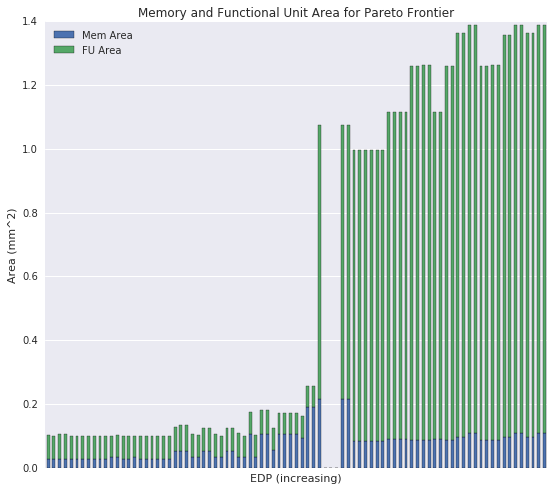

In [376]:
sns.set()
ax = plot_dat[['memA','fuA']].plot(kind='bar', stacked=True, figsize=FIGSIZE)
plt.title('Memory and Functional Unit Area for Pareto Frontier')
plt.xlabel('EDP (increasing)')
plt.xticks([])
plt.ylabel('Area (mm^2)')
plt.legend(['Mem Area', 'FU Area'], loc='upper left')
# plt.yscale('log', basey=10)
# plt.xticks(np.arange(len(plot_dat)), plot_dat['EDP'].values)
# ax.xaxis.set_visible(False)
plt.savefig('Area_Barplot.png', dpi = 300, bbox_inches='tight')
plt.show()

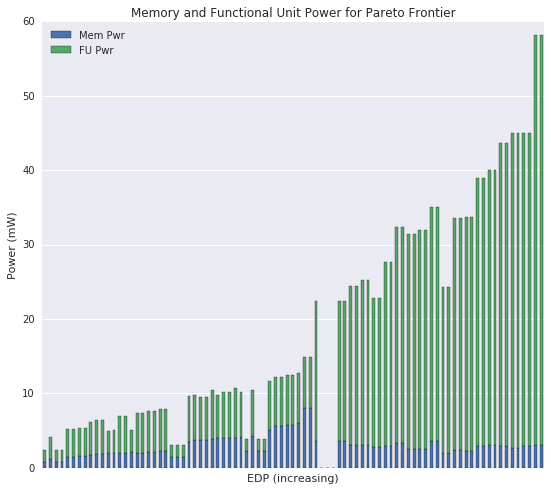

In [377]:
sns.set()
ax = plot_dat[['memP','fuP']].plot(kind='bar', stacked=True, figsize=FIGSIZE)
plt.title('Memory and Functional Unit Power for Pareto Frontier')
plt.xlabel('EDP (increasing)')
plt.xticks([])
plt.ylabel('Power (mW)')
plt.legend(['Mem Pwr', 'FU Pwr'], loc='upper left')
# plt.yscale('log', basey=10)
# ax.xaxis.set_visible(False)
plt.savefig('Pwr_Barplot.png', dpi = 300, bbox_inches='tight')
plt.show()

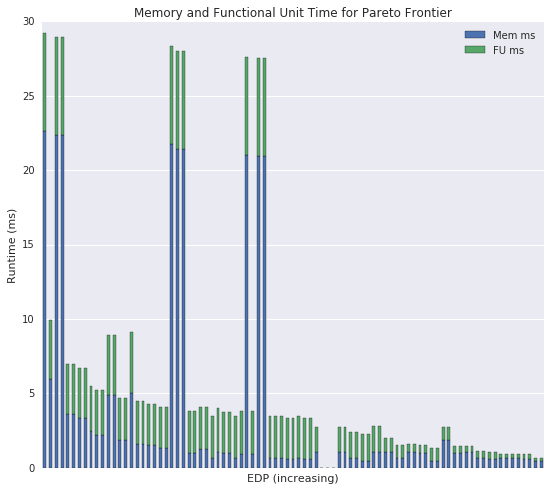

In [378]:
sns.set()
ax = plot_dat[['memT','fuT']].plot(kind='bar', stacked=True, figsize=FIGSIZE)
plt.title('Memory and Functional Unit Time for Pareto Frontier')
plt.xlabel('EDP (increasing)')
plt.ylabel('Runtime (ms)')
plt.legend(['Mem ms', 'FU ms'], loc='upper right')
# plt.yscale('log', basey=10)
# ax.xaxis.set_visible(False)
plt.xticks([])
plt.savefig('Latency_Barplot.png', dpi = 300, bbox_inches='tight')
plt.show()